In [1]:
import os
import datetime
import random
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from category_encoders import CountEncoder

from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
#sns.set(font='Yu Gothic')

from matplotlib_venn import venn2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [3]:
# Congig
SEED = 42
FOLD = 5
pd.get_option('display.max_columns')
seed_everything(SEED)

In [4]:
train = pd.read_csv('./train_kfold.csv',index_col=0)
test = pd.read_csv('./test_geo.csv',index_col=0)
sample_submission = pd.read_csv("./sample_submission.csv",index_col=0, header=None,names=['id', 'RF_pred'])
train.shape, test.shape, sample_submission.shape

((19984, 25), (19702, 23), (19702, 1))

### 欠損値

In [5]:
train.isnull().sum()

created_at              0
tree_dbh                0
curb_loc                0
health                  0
steward             14883
guards              14943
sidewalk                0
user_type               0
problems            12243
spc_common              0
spc_latin               0
nta                     0
nta_name                0
borocode                0
boro_ct                 0
boroname                0
zip_city                0
cb_num                  0
st_senate               0
st_assem                0
cncldist                0
combined_address        0
latitude                0
longitude               0
kfold                   0
dtype: int64

In [6]:
# 欠損値
train.fillna('NULL', inplace=True)
train.isnull().sum()

created_at          0
tree_dbh            0
curb_loc            0
health              0
steward             0
guards              0
sidewalk            0
user_type           0
problems            0
spc_common          0
spc_latin           0
nta                 0
nta_name            0
borocode            0
boro_ct             0
boroname            0
zip_city            0
cb_num              0
st_senate           0
st_assem            0
cncldist            0
combined_address    0
latitude            0
longitude           0
kfold               0
dtype: int64

In [7]:
test.isnull().sum()

created_at              0
tree_dbh                0
curb_loc                0
steward             14526
guards              14567
sidewalk                0
user_type               0
problems            12045
spc_common              0
spc_latin               0
nta                     0
nta_name                0
borocode                0
boro_ct                 0
boroname                0
zip_city                0
cb_num                  0
st_senate               0
st_assem                0
cncldist                0
combined_address        0
latitude                0
longitude               0
dtype: int64

In [8]:
# 欠損値
test.fillna('NULL', inplace=True)
test.isnull().sum()

created_at          0
tree_dbh            0
curb_loc            0
steward             0
guards              0
sidewalk            0
user_type           0
problems            0
spc_common          0
spc_latin           0
nta                 0
nta_name            0
borocode            0
boro_ct             0
boroname            0
zip_city            0
cb_num              0
st_senate           0
st_assem            0
cncldist            0
combined_address    0
latitude            0
longitude           0
dtype: int64

In [9]:
train.head()

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,...,boroname,zip_city,cb_num,st_senate,st_assem,cncldist,combined_address,latitude,longitude,kfold
0,2015-06-29,14,OnCurb,1,NULL,NULL,Damage,Volunteer,NULL,English oak,...,Queens,Little Neck,411,11,25,23,"Little Neck, Queens",40.774534,-73.741256,2
1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NULL,crimson king maple,...,Bronx,Bronx,207,33,78,15,"Bronx, Bronx",40.850656,-73.866524,3
2,2015-09-13,26,OnCurb,2,NULL,NULL,NoDamage,Volunteer,StonesBranchLights,English oak,...,Staten Island,Staten Island,503,24,62,51,"Staten Island, Staten Island",40.583456,-74.149605,2
3,2016-05-09,15,OnCurb,0,NULL,NULL,Damage,NYC Parks Staff,NULL,honeylocust,...,Staten Island,Staten Island,503,24,62,51,"Staten Island, Staten Island",40.583456,-74.149605,2
4,2016-06-24,23,OnCurb,1,NULL,NULL,NoDamage,Volunteer,Stones,London planetree,...,Manhattan,New York,110,30,70,9,"New York, Manhattan",40.789624,-73.959894,2


In [10]:
test.head()

,created_at,tree_dbh,curb_loc,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,...,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist,combined_address,latitude,longitude
0,2015-09-08,15,OnCurb,NULL,NULL,Damage,NYC Parks Staff,NULL,Callery pear,Pyrus calleryana,...,3062000,Brooklyn,Brooklyn,315,22,45,48,"Brooklyn, Brooklyn",40.652601,-73.949721
1,2015-10-15,5,OnCurb,1or2,NULL,NoDamage,Volunteer,NULL,cherry,Prunus,...,2045101,Bronx,Bronx,212,34,81,11,"Bronx, Bronx",40.850656,-73.866524
2,2016-08-03,4,OnCurb,NULL,Unsure,NoDamage,Volunteer,NULL,littleleaf linden,Tilia cordata,...,4013800,Queens,Kew Gardens,409,14,27,29,"Kew Gardens, Queens",40.713941,-73.830742
3,2015-08-06,7,OnCurb,NULL,NULL,NoDamage,TreesCount Staff,NULL,dawn redwood,Metasequoia glyptostroboides,...,3000301,Brooklyn,Brooklyn,302,26,52,33,"Brooklyn, Brooklyn",40.652601,-73.949721
4,2015-10-21,6,OnCurb,1or2,Helpful,NoDamage,TreesCount Staff,Stones,purple-leaf plum,Prunus cerasifera,...,3025100,Brooklyn,Brooklyn,303,25,56,36,"Brooklyn, Brooklyn",40.652601,-73.949721


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19984 entries, 0 to 19983
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   created_at        19984 non-null  object 
 1   tree_dbh          19984 non-null  int64  
 2   curb_loc          19984 non-null  object 
 3   health            19984 non-null  int64  
 4   steward           19984 non-null  object 
 5   guards            19984 non-null  object 
 6   sidewalk          19984 non-null  object 
 7   user_type         19984 non-null  object 
 8   problems          19984 non-null  object 
 9   spc_common        19984 non-null  object 
 10  spc_latin         19984 non-null  object 
 11  nta               19984 non-null  object 
 12  nta_name          19984 non-null  object 
 13  borocode          19984 non-null  int64  
 14  boro_ct           19984 non-null  int64  
 15  boroname          19984 non-null  object 
 16  zip_city          19984 non-null  object 
 17

## ターゲットの分布
### 木の健康状態（目的変数）
### 0:Fair（普通） 1:Good（良い） 2:Poor（悪い）

In [12]:
train["health"].value_counts()

health
1    15751
0     3535
2      698
Name: count, dtype: int64

<Axes: xlabel='health', ylabel='count'>

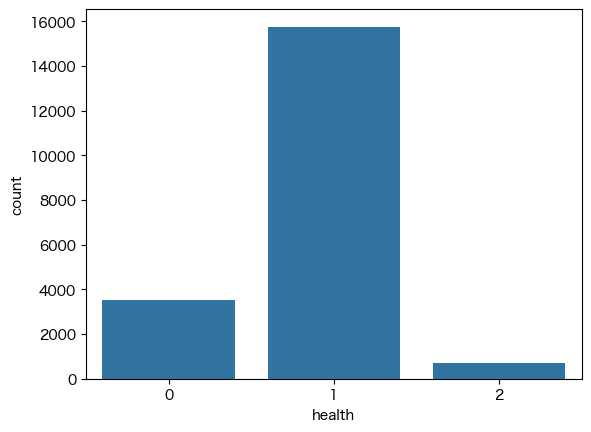

In [13]:
sns.countplot(data=train, x="health")

In [14]:
## For Target Enc
#train["target"] = train["health"]
#train["target"] = train["target"].replace(2,-1)
#sns.countplot(data=train, x="target")

In [15]:
#train.corr()

# 前処理部分

In [16]:
#Tag
#test["health"] = -99
test["kfold"] = -99
train["Tag"] = 1
test["Tag"] = 0

In [17]:
df_concat = pd.concat([train, test])
df_concat.shape

(39686, 26)

### 欠損値

In [18]:
df_concat.isnull().sum()

created_at              0
tree_dbh                0
curb_loc                0
health              19702
steward                 0
guards                  0
sidewalk                0
user_type               0
problems                0
spc_common              0
spc_latin               0
nta                     0
nta_name                0
borocode                0
boro_ct                 0
boroname                0
zip_city                0
cb_num                  0
st_senate               0
st_assem                0
cncldist                0
combined_address        0
latitude                0
longitude               0
kfold                   0
Tag                     0
dtype: int64

### 多重共線性

In [19]:
df_concat = df_concat.drop('borocode',axis=1)
df_concat = df_concat.drop('boroname',axis=1)
df_concat = df_concat.drop('zip_city',axis=1)
df_concat = df_concat.drop('combined_address',axis=1)

### 特徴量作成

In [20]:
def fea_eng(df):

    # 日時
    df["created_at"] = pd.to_datetime(df["created_at"])
    df["year"] = df["created_at"].apply(lambda x: x.year)
    df["quarter"] = df["created_at"].apply(lambda x: x.quarter)  # 2024/01/07
    df["month"] = df["created_at"].apply(lambda x: x.month)
    #df["day"] = df["created_at"].apply(lambda x: x.day)
    df = df.drop('created_at',axis=1)
    
    # user_type
    df['Staff'] = df['user_type'].map(lambda x: 1 if 'Staff' in str(x) else 0)
    
    df['bool_problems'] = df['problems'].apply(lambda x: 0 if x=='NULL' else 1)

    # spc_common
    df['oak'] = df['spc_common'].map(lambda x: 1 if 'oak' in str(x) else 0)
    df['maple'] = df['spc_common'].map(lambda x: 1 if 'maple' in str(x) else 0)
    df['pine'] = df['spc_common'].map(lambda x: 1 if 'pine' in str(x) else 0)
    df['ash'] = df['spc_common'].map(lambda x: 1 if 'ash' in str(x) else 0) 
    df['white'] = df['spc_common'].map(lambda x: 1 if 'white' in str(x) else 0) 
    df['black'] = df['spc_common'].map(lambda x: 1 if 'black' in str(x) else 0) 
    df['red'] = df['spc_common'].map(lambda x: 1 if 'red' in str(x) else 0)

    # 2024/01/07
    df['American'] = df['spc_common'].map(lambda x: 1 if 'American' in str(x) else 0)
    df['Chinese'] = df['spc_common'].map(lambda x: 1 if 'Chinese' in str(x) else 0)    
    df['Japanese'] = df['spc_common'].map(lambda x: 1 if 'Japanese' in str(x) else 0)
    
    # Category組み合わせ
    df["On_SIDEWALK"] = df['curb_loc'].astype(str) + "_" + df['sidewalk'].astype(str)
    df["guards_SIDEWALK"] = df['guards'].astype(str) + "_" + df['sidewalk'].astype(str)
    df["problems_SIDEWALK"] = df['problems'].astype(str) + "_" + df['sidewalk'].astype(str)      
    df["spc_SIDEWALK"] = df['spc_common'].astype(str) + "_" + df['sidewalk'].astype(str)  
    
    df["curb_NTA"] = df['curb_loc'].astype(str) + "_" + df['nta'].astype(str)
    df["guards_NTA"] = df['guards'].astype(str) + "_" + df['nta'].astype(str)     
    df["sidewalk_NTA"] = df['sidewalk'].astype(str) + "_" + df['nta'].astype(str)
    #df["user_NTA"] = df['user_type'].astype(str) + "_" + df['nta'].astype(str)
    df["problems_NTA"] = df['problems'].astype(str) + "_" + df['nta'].astype(str)
    df["spc_NTA"] = df['spc_common'].astype(str) + "_" + df['nta'].astype(str)    

    df["problems_GUARDS"] = df['problems'].astype(str) + "_" + df['guards'].astype(str)     

    return df

In [21]:
%%time
df_concat = fea_eng(df_concat)
df_concat.shape

CPU times: user 213 ms, sys: 5.19 ms, total: 218 ms
Wall time: 218 ms


(39686, 46)

In [22]:
# For Target Encoding
train = fea_eng(train)

## spc_commonごとのtree_dbh

In [23]:
temp_mean = df_concat[["tree_dbh", "spc_common"]].groupby("spc_common").mean().reset_index().rename({"tree_dbh":"Mean_tree_dbh"}, axis=1)
df_concat = df_concat.merge(temp_mean, how = "left", on = "spc_common")

In [24]:
df_concat["dbh_per_SpcAve"] = df_concat["tree_dbh"] / df_concat["Mean_tree_dbh"]
df_concat = df_concat.drop('Mean_tree_dbh',axis=1)

In [25]:
#temp_mean = df_concat[["tree_dbh", "nta"]].groupby("nta").mean().reset_index().rename({"tree_dbh":"NTA_tree_dbh"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "nta")

In [26]:
#df_concat["dbh_per_NTA"] = df_concat["tree_dbh"] / df_concat["NTA_tree_dbh"]
#df_concat = df_concat.drop('NTA_tree_dbh',axis=1)

## 位置情報

In [27]:
# 緯度、経度
df_concat['r'] = np.sqrt(df_concat['latitude']**2 + df_concat['longitude']**2)
df_concat['theta'] = np.arctan2(df_concat['latitude'], df_concat['longitude'])

In [28]:
df_concat['rot_15_x'] = (np.cos(np.radians(15)) * df_concat['longitude']) + (np.sin(np.radians(15)) * df_concat['latitude'])
df_concat['rot_15_y'] = (np.cos(np.radians(15)) * df_concat['latitude']) + (np.sin(np.radians(15)) * df_concat['longitude'])
df_concat['rot_30_x'] = (np.cos(np.radians(30)) * df_concat['longitude']) + (np.sin(np.radians(30)) * df_concat['latitude'])
df_concat['rot_30_y'] = (np.cos(np.radians(30)) * df_concat['latitude']) + (np.sin(np.radians(30)) * df_concat['longitude'])
df_concat['rot_45_x'] = (np.cos(np.radians(45)) * df_concat['longitude']) + (np.sin(np.radians(45)) * df_concat['latitude'])
df_concat['rot_45_y'] = (np.cos(np.radians(45)) * df_concat['latitude']) + (np.sin(np.radians(45)) * df_concat['longitude'])

### カラム

In [29]:
df_concat.head()

,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,...,problems_GUARDS,dbh_per_SpcAve,r,theta,rot_15_x,rot_15_y,rot_30_x,rot_30_y,rot_45_x,rot_45_y
0,14,OnCurb,1.0,NULL,NULL,Damage,Volunteer,NULL,English oak,Quercus robur,...,NULL_NULL,1.133911,84.263489,2.636495,-60.675358,20.299534,-43.474534,-1.558846,-23.310993,-23.310993
1,5,OnCurb,1.0,3or4,Helpful,NoDamage,Volunteer,NULL,crimson king maple,Acer platanoides 'Crimson King',...,NULL_Helpful,0.492248,84.409949,2.636424,-60.776656,20.340640,-43.544958,-1.555556,-23.345744,-23.345744
2,26,OnCurb,2.0,NULL,NULL,NoDamage,Volunteer,StonesBranchLights,English oak,Quercus robur,...,StonesBranchLights_NULL,2.105835,84.529171,2.640810,-61.119247,20.009278,-43.923714,-1.928499,-23.734852,-23.734852
3,15,OnCurb,0.0,NULL,NULL,Damage,NYC Parks Staff,NULL,honeylocust,Gleditsia triacanthos var. inermis,...,NULL_NULL,1.306129,84.529171,2.640810,-61.119247,20.009278,-43.923714,-1.928499,-23.734852,-23.734852
4,23,OnCurb,1.0,NULL,NULL,NoDamage,Volunteer,Stones,London planetree,Platanus x acerifolia,...,Stones_NULL,1.183565,84.462177,2.637591,-60.882640,20.257522,-43.656335,-1.655096,-23.454923,-23.454923


In [30]:
df_concat.columns

Index(['tree_dbh', 'curb_loc', 'health', 'steward', 'guards', 'sidewalk',
       'user_type', 'problems', 'spc_common', 'spc_latin', 'nta', 'nta_name',
       'boro_ct', 'cb_num', 'st_senate', 'st_assem', 'cncldist', 'latitude',
       'longitude', 'kfold', 'Tag', 'year', 'quarter', 'month', 'Staff',
       'bool_problems', 'oak', 'maple', 'pine', 'ash', 'white', 'black', 'red',
       'American', 'Chinese', 'Japanese', 'On_SIDEWALK', 'guards_SIDEWALK',
       'problems_SIDEWALK', 'spc_SIDEWALK', 'curb_NTA', 'guards_NTA',
       'sidewalk_NTA', 'problems_NTA', 'spc_NTA', 'problems_GUARDS',
       'dbh_per_SpcAve', 'r', 'theta', 'rot_15_x', 'rot_15_y', 'rot_30_x',
       'rot_30_y', 'rot_45_x', 'rot_45_y'],
      dtype='object')

In [31]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39686 entries, 0 to 39685
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tree_dbh           39686 non-null  int64  
 1   curb_loc           39686 non-null  object 
 2   health             19984 non-null  float64
 3   steward            39686 non-null  object 
 4   guards             39686 non-null  object 
 5   sidewalk           39686 non-null  object 
 6   user_type          39686 non-null  object 
 7   problems           39686 non-null  object 
 8   spc_common         39686 non-null  object 
 9   spc_latin          39686 non-null  object 
 10  nta                39686 non-null  object 
 11  nta_name           39686 non-null  object 
 12  boro_ct            39686 non-null  int64  
 13  cb_num             39686 non-null  int64  
 14  st_senate          39686 non-null  int64  
 15  st_assem           39686 non-null  int64  
 16  cncldist           396

### Count Encoding

In [32]:
#categoricals = ["curb_loc", "steward", "guards", "sidewalk", "user_type","problems","spc_common","spc_latin","nta","nta_name","boroname","zip_city"]

# 欠損値のあるカテゴリ
categoricals = ["steward","guards","problems"]

for col in categoricals:
    encoder = CountEncoder()
    encoder.fit(df_concat[col])
    df_concat['%s_count'%col] = encoder.transform(df_concat[col])

### Label Encoding

In [33]:
# LabelEncoder
# 文字列を数値に変換したい
def preprocess(df):
    df["curb_loc"] = LabelEncoder().fit_transform(df["curb_loc"])
    df["steward"] = LabelEncoder().fit_transform(df["steward"])
    df["guards"] = LabelEncoder().fit_transform(df["guards"])
    df["sidewalk"] = LabelEncoder().fit_transform(df["sidewalk"])
    df["user_type"] = LabelEncoder().fit_transform(df["user_type"])
    df["problems"] = LabelEncoder().fit_transform(df["problems"])
    df["spc_common"] = LabelEncoder().fit_transform(df["spc_common"])
    df["spc_latin"] = LabelEncoder().fit_transform(df["spc_latin"])
    df["nta"] = LabelEncoder().fit_transform(df["nta"])
    df["nta_name"] = LabelEncoder().fit_transform(df["nta_name"])

    # 独自
    df["On_SIDEWALK"] = LabelEncoder().fit_transform(df["On_SIDEWALK"])
    df["guards_SIDEWALK"] = LabelEncoder().fit_transform(df["guards_SIDEWALK"])
    df["problems_SIDEWALK"] = LabelEncoder().fit_transform(df["problems_SIDEWALK"])
    df["spc_SIDEWALK"] = LabelEncoder().fit_transform(df["spc_SIDEWALK"])
    
    df["curb_NTA"] = LabelEncoder().fit_transform(df["curb_NTA"])
    df["guards_NTA"] = LabelEncoder().fit_transform(df["guards_NTA"])
    df["sidewalk_NTA"] = LabelEncoder().fit_transform(df["sidewalk_NTA"])
    #df["user_NTA"] = LabelEncoder().fit_transform(df["user_NTA"])
    df["problems_NTA"] = LabelEncoder().fit_transform(df["problems_NTA"])
    df["spc_NTA"] = LabelEncoder().fit_transform(df["spc_NTA"])

    df["problems_GUARDS"] = LabelEncoder().fit_transform(df["problems_GUARDS"])
    return df 

In [34]:
%%time
df_concat = preprocess(df_concat)

CPU times: user 88.5 ms, sys: 2.2 ms, total: 90.7 ms
Wall time: 89.9 ms


In [35]:
df_concat.head()

,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,...,theta,rot_15_x,rot_15_y,rot_30_x,rot_30_y,rot_45_x,rot_45_y,steward_count,guards_count,problems_count
0,14,1,1.0,3,2,0,2,10,17,98,...,2.636495,-60.675358,20.299534,-43.474534,-1.558846,-23.310993,-23.310993,29409,29510,24288
1,5,1,1.0,1,1,1,2,10,56,7,...,2.636424,-60.776656,20.340640,-43.544958,-1.555556,-23.345744,-23.345744,2068,7366,24288
2,26,1,2.0,3,2,1,2,29,17,98,...,2.640810,-61.119247,20.009278,-43.923714,-1.928499,-23.734852,-23.734852,29409,29510,1529
3,15,1,0.0,3,2,0,0,10,73,52,...,2.640810,-61.119247,20.009278,-43.923714,-1.928499,-23.734852,-23.734852,29409,29510,24288
4,23,1,1.0,3,2,1,2,28,28,81,...,2.637591,-60.882640,20.257522,-43.656335,-1.655096,-23.454923,-23.454923,29409,29510,4455


### TrainとTestに戻す

In [36]:
#data load
train = df_concat[df_concat['Tag']==1]
test = df_concat[df_concat['Tag']==0]

In [37]:
train = train.drop('Tag',axis=1)
test = test.drop('Tag',axis=1)
train.shape, test.shape

((19984, 57), (19702, 57))

In [38]:
train['id'] = train.index

In [39]:
train.head()

,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,...,rot_15_x,rot_15_y,rot_30_x,rot_30_y,rot_45_x,rot_45_y,steward_count,guards_count,problems_count,id
0,14,1,1.0,3,2,0,2,10,17,98,...,-60.675358,20.299534,-43.474534,-1.558846,-23.310993,-23.310993,29409,29510,24288,0
1,5,1,1.0,1,1,1,2,10,56,7,...,-60.776656,20.340640,-43.544958,-1.555556,-23.345744,-23.345744,2068,7366,24288,1
2,26,1,2.0,3,2,1,2,29,17,98,...,-61.119247,20.009278,-43.923714,-1.928499,-23.734852,-23.734852,29409,29510,1529,2
3,15,1,0.0,3,2,0,0,10,73,52,...,-61.119247,20.009278,-43.923714,-1.928499,-23.734852,-23.734852,29409,29510,24288,3
4,23,1,1.0,3,2,1,2,28,28,81,...,-60.882640,20.257522,-43.656335,-1.655096,-23.454923,-23.454923,29409,29510,4455,4


# 学習部

In [40]:
useful_features = [c for c in train.columns if c not in ("id","health", "created_at", "kfold","target","spc_latin","nta_name")]
useful_features

['tree_dbh',
 'curb_loc',
 'steward',
 'guards',
 'sidewalk',
 'user_type',
 'problems',
 'spc_common',
 'nta',
 'boro_ct',
 'cb_num',
 'st_senate',
 'st_assem',
 'cncldist',
 'latitude',
 'longitude',
 'year',
 'quarter',
 'month',
 'Staff',
 'bool_problems',
 'oak',
 'maple',
 'pine',
 'ash',
 'white',
 'black',
 'red',
 'American',
 'Chinese',
 'Japanese',
 'On_SIDEWALK',
 'guards_SIDEWALK',
 'problems_SIDEWALK',
 'spc_SIDEWALK',
 'curb_NTA',
 'guards_NTA',
 'sidewalk_NTA',
 'problems_NTA',
 'spc_NTA',
 'problems_GUARDS',
 'dbh_per_SpcAve',
 'r',
 'theta',
 'rot_15_x',
 'rot_15_y',
 'rot_30_x',
 'rot_30_y',
 'rot_45_x',
 'rot_45_y',
 'steward_count',
 'guards_count',
 'problems_count']

In [41]:
test_predictions = []
valid_predictions = {}
scores = []

for fold in range(FOLD):

    xtrain = train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test[useful_features]

    # For Stacking
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.health
    yvalid = xvalid.health
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    model = RandomForestClassifier(criterion='entropy',
                                   random_state=SEED,
                                   class_weight='balanced')
    model.fit(xtrain, ytrain)
    
    # For Validation
    preds_valid = model.predict_proba(xvalid)
    preds_valid = np.argmax(preds_valid, axis=1)  # 最尤と判断したクラスを選ぶ
    valid_predictions.update(dict(zip(valid_ids, preds_valid)))

    ###########
    # 推論部分 #
    ##########    
    # For Test
    test_preds = model.predict_proba(xtest)
    test_predictions.append(test_preds)

    # F1を計算する
    score = f1_score(yvalid, preds_valid, average='macro')
    print(f'fold {fold} F1: {score}')
    scores.append(score)

    #print(model.params)

print(np.mean(scores), np.std(scores))

# For Blending and Stacking
final_valid_predictions = pd.DataFrame.from_dict(valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "RF_pred"]
final_valid_predictions.to_csv("train_RF_20240107_pred.csv", index=False)

final_test_predictions = np.average(test_predictions, axis = 0)
pred = np.argmax(final_test_predictions, axis=1)  # 最尤と判断したクラスを選ぶ
sample_submission['RF_pred'] = pred
sample_submission.to_csv("test_RF_20240107_pred.csv",index=False)

fold 0 F1: 0.29821323319099524
fold 1 F1: 0.30233393267405856
fold 2 F1: 0.3009570855202223
fold 3 F1: 0.3011304915586233
fold 4 F1: 0.30085789429608906
0.30069852744799774 0.0013513016583404486


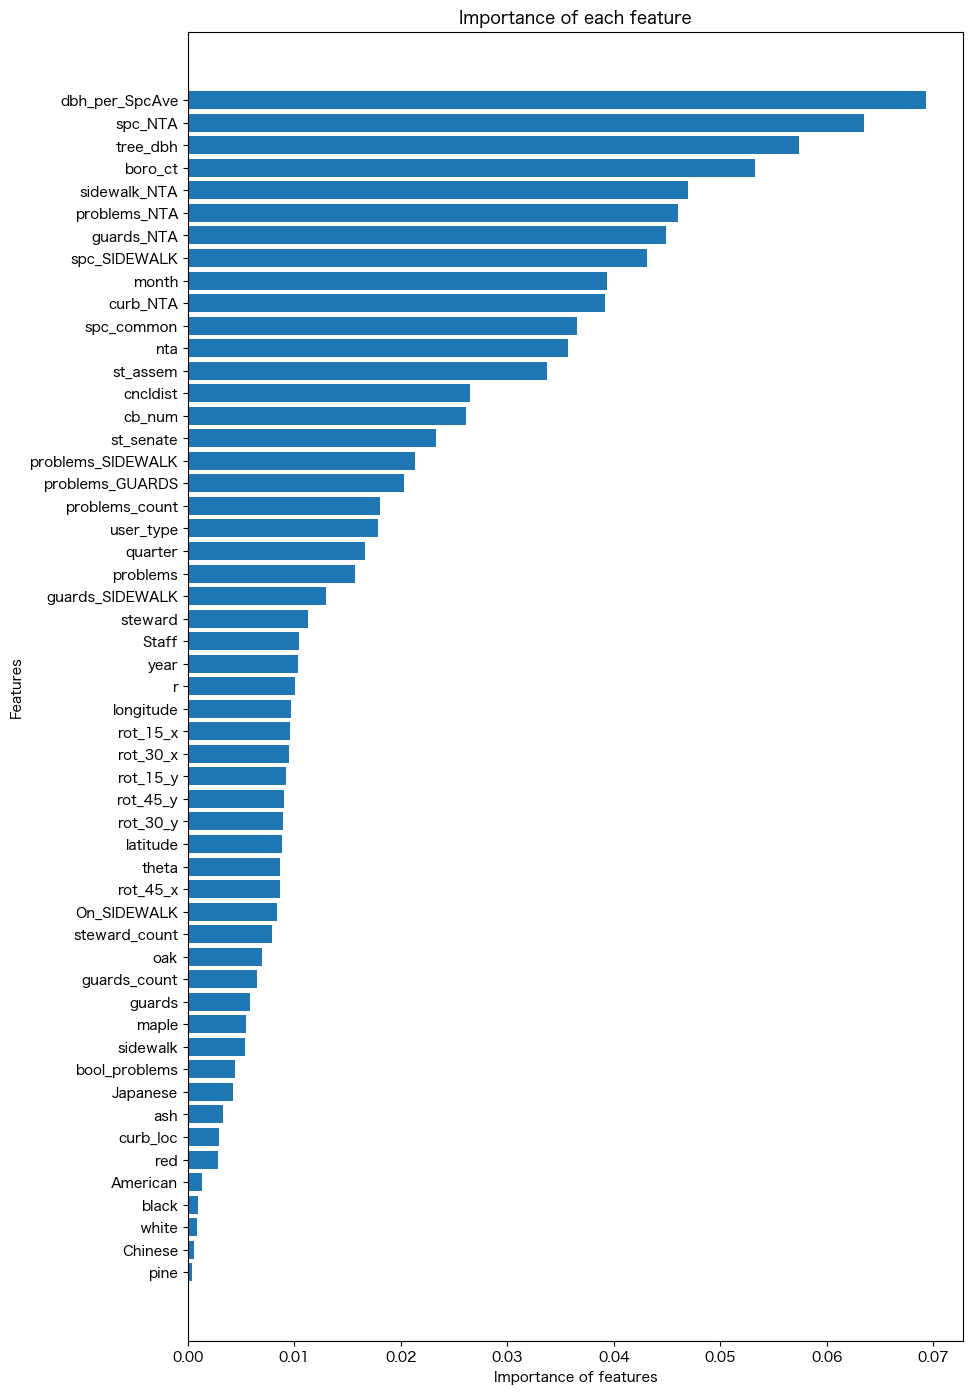

In [42]:
imp = model.feature_importances_
names = xtrain.columns
 
imp, names = zip(*sorted(zip(imp, names)))

plt.figure(figsize = (10,17))
plt.barh(range(len(names)), imp, align='center')
plt.yticks(range(len(names)), names)
plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Importance of each feature')
plt.show()

# 解析

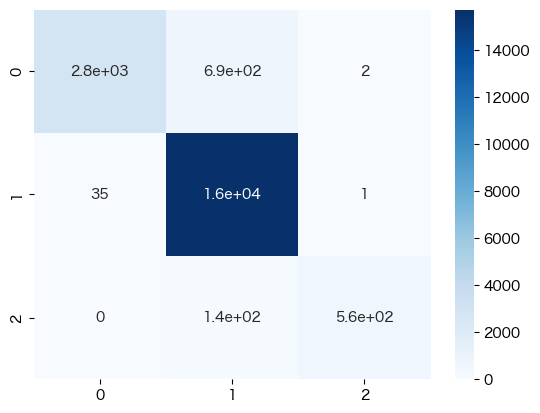

In [43]:
# confusion　matrix
train_pred = model.predict_proba(train[useful_features]).argmax(axis=1)
cm = confusion_matrix(train['health'], train_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()

## 提出

In [44]:
sample_submission.head()

,RF_pred
id,
19984,1
19985,1
19986,1
19987,1
19988,1


In [45]:
test_predictions

[array([[0.14, 0.82, 0.04],
        [0.26, 0.74, 0.  ],
        [0.1 , 0.88, 0.02],
        ...,
        [0.04, 0.91, 0.05],
        [0.09, 0.91, 0.  ],
        [0.22, 0.77, 0.01]]),
 array([[0.32, 0.65, 0.03],
        [0.16, 0.83, 0.01],
        [0.15, 0.79, 0.06],
        ...,
        [0.04, 0.91, 0.05],
        [0.18, 0.82, 0.  ],
        [0.2 , 0.77, 0.03]]),
 array([[0.2 , 0.79, 0.01],
        [0.22, 0.78, 0.  ],
        [0.12, 0.86, 0.02],
        ...,
        [0.  , 0.99, 0.01],
        [0.12, 0.84, 0.04],
        [0.1 , 0.9 , 0.  ]]),
 array([[0.26, 0.74, 0.  ],
        [0.25, 0.74, 0.01],
        [0.14, 0.81, 0.05],
        ...,
        [0.01, 0.97, 0.02],
        [0.18, 0.76, 0.06],
        [0.17, 0.83, 0.  ]]),
 array([[0.34, 0.63, 0.03],
        [0.34, 0.66, 0.  ],
        [0.19, 0.8 , 0.01],
        ...,
        [0.04, 0.94, 0.02],
        [0.16, 0.81, 0.03],
        [0.14, 0.84, 0.02]])]

In [46]:
final_test_predictions = np.average(test_predictions, axis = 0)
final_test_predictions

array([[0.252, 0.726, 0.022],
       [0.246, 0.75 , 0.004],
       [0.14 , 0.828, 0.032],
       ...,
       [0.026, 0.944, 0.03 ],
       [0.146, 0.828, 0.026],
       [0.166, 0.822, 0.012]])

In [47]:
pred = np.argmax(final_test_predictions, axis=1)  # 最尤と判断したクラスを選ぶ

In [48]:
pred

array([1, 1, 1, ..., 1, 1, 1])

In [49]:
sample_submission['RF_pred'] = pred
sample_submission.head()

,RF_pred
id,
19984,1
19985,1
19986,1
19987,1
19988,1


In [50]:
#sample_submission.to_csv('./submit_1224_1st.csv', header=None)

### 木の健康状態（目的変数）
0:Fair（普通） 1:Good（良い） 2:Poor（悪い）

In [51]:
sample_submission['RF_pred'].value_counts()

RF_pred
1    19610
0       92
Name: count, dtype: int64

health<BR>
1    15751<BR>
0     3535<BR>
2      698

In [52]:
sample_submission.shape

(19702, 1)